# 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive
%cd ANDL_HOMEWORK1_LINK

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive
/gdrive/.shortcut-targets-by-id/14RasmCIKqhEPRMZcyNhd3qdplUPJ-lAw/Homework 1


# ⚙️ Import Libraries

In [ ]:
%pip install keras_cv

In [ ]:
# Set seed for reproducibility
seed = 42
# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set GPU
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical

# Import Keras_cv for augmentations
import keras_cv

2.17.1


# ⏳ Load the Data

In [ ]:
# Load the NPZ file
data = np.load('dataset/cleaned_dataset.npz', allow_pickle=True)

# Print the keys in the file to see what arrays are stored
print("Keys in the npz file:", data.files)

#Store Data in Arrays
images_data = data['images']
labels_data = data['labels']

# Data shapes
INPUT_SHAPE = images_data.shape[1:]

print("Number of Images :", len(images_data))
print("Labels :", len(labels_data))

print("Shape of Images Array :", images_data.shape)
print("Shape of Labels Array :", labels_data.shape)

Keys in the npz file: ['images', 'labels']
Number of Images : 11959
Labels : 11959
Shape of Images Array : (11959, 96, 96, 3)
Shape of Labels Array : (11959, 1)


### ➗ Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(images_data, labels_data, test_size=0.2, random_state=42, stratify=labels_data)

# Second split: Split the training set into 80% training and 20% validation (this means 64% train, 16% val overall)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Dataset Shapes
IMAGE_SIZE = INPUT_SHAPE[:2]
NUM_CLASSES = 8

# Convert TRAIN and VALIDATION labels to categorical
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)


# Preprocessing

In [ ]:
# PREPROCESSING PARAMETERS
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Define Augmenter
augmenter = keras_cv.layers.Augmenter(
	layers=[
		keras_cv.layers.ChannelShuffle(groups=3),
		keras_cv.layers.RandAugment(
			# parameters set as in the paper
			value_range = (0,255),
			augmentations_per_image=8,
			magnitude=0.2,
			rate=0.75,
			geometric=True,
			seed=seed),
		keras_cv.layers.AugMix(
			severity=0.65,
			value_range=(0, 255),
		),
		keras_cv.layers.GridMask(),
	]
)


In [ ]:
# Convert Images and Labels of TRAIN into float32 tf array for keras_cv preprocessing
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Preprocess TRAIN
mixorcut = keras_cv.layers.RandomChoice(
    [
        keras_cv.layers.CutMix(),
        keras_cv.layers.MixUp()
	],
    batchwise=True
)

moc_data = mixorcut(
	{
	"images": X_train,
	"labels" : y_train,
	}
)

# Convert back preprocessed TRAIN into numpy array
X_train_np = moc_data["images"].numpy()
y_train_np = moc_data["labels"].numpy()

# Convert VALIDATION as float32 as already done for TRAIN
X_val = X_val.astype('float32')

# Shuffle and batch TRAIN
train_ds_rand = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE)

train_ds_rand = train_ds_rand.prefetch(AUTOTUNE)

# Apply Gaussian noise to TRAIN
gaussian_noise = tfk.layers.GaussianNoise(0.3)
train_ds_rand = train_ds_rand.map(lambda x, y: (gaussian_noise(x, training=True), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# Define a function that takes an image and return n augmented version of it
def augment(image, num_augmentations=2):
	augmented_images = [augmenter(tf.expand_dims(image, axis=0)) for _ in range(num_augmentations)]
	augmented_images = [tf.squeeze(img, axis=0) for img in augmented_images]
	return augmented_images


# Define a function that takes an image and his label
# and returns an array with augmented version of the image with the same label
def augment_data(image, label):
	augmented_images = augment(image)
	images_with_original = [image] + augmented_images  # Include the original image
	labels_with_original = [label] * len(images_with_original)  # Repeat the label for both original and augmented images
	return tf.data.Dataset.from_tensor_slices((images_with_original, labels_with_original))


# Apply the augmentation function to each image in the dataset
augmented_dataset = train_ds_rand.unbatch().flat_map(
	lambda image, label: augment_data(image, label))

# Shuffle vector and build batches
augmented_dataset = augmented_dataset.shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(AUTOTUNE).unbatch()

In [ ]:
# Convert the augmented dataset to a list of images and label
# This is done only for decrease computation time, completing augmentation before training
n_augmented_images = len(X_train_np) * 3

augmented_images = np.empty((n_augmented_images, 96, 96, 3), dtype=np.uint8)
augmented_labels = np.empty((n_augmented_images,8), dtype=np.float32)

i = 0
prog = 0.0
for image, label in augmented_dataset:
	if(i/n_augmented_images >= prog + 0.1):
		prog += 0.1
		print(f"{int(prog*100)}%", end=" ")
	augmented_images[i] = image
	augmented_labels[i] = label
	i = i + 1

def output_data(filename, imgs, labels):
    np.savez_compressed(filename + ".npz", images=imgs, labels=labels)

output_data("preprocessed_dataset/jgiga_augm_train", augmented_images, augmented_labels)
output_data("preprocessed_dataset/jgiga_augm_val", X_val, y_val)
output_data("preprocessed_dataset/jgiga_augm_test", X_test, y_test)

10% 20% 30% 40% 50% 60% 70% 80% 89% 

In [ ]:
# CLEANUP
del mixorcut, gaussian_noise
del X_train, y_train, moc_data, X_train_np, y_train_np, train_ds_rand, augmented_dataset, data

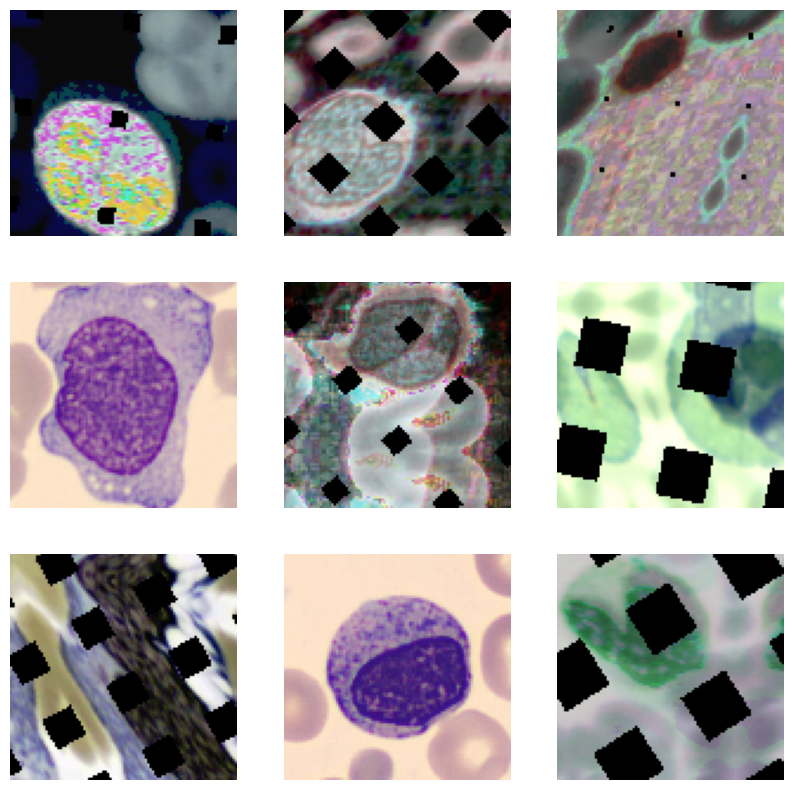

In [ ]:
# Plot some example of dataset
plt.figure(figsize=(10, 10))
for i, image in enumerate(augmented_images[:9]):
	ax = plt.subplot(3, 3, i + 1)
	plt.imshow(image.astype('uint8'))
	plt.axis("off")

plt.show()

# Model

### Callback functions

In [ ]:
# Training callbacks
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',          # Monitor validation accuracy
    mode='max',                  # Mode 'max' because we want to maximize validation accuracy
    patience=13,                  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True)   # Restore model weights from the epoch with the best value of the monitored quantity

reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5
    )

callbacks = [early_stopping, reduce_lr_on_plateau]

### Class Weights

In [ ]:
# Class weights have been precomputed onto the cleaned dataset
class_weights =  {0: 1.7847481343283582, 1: 0.6784574468085106, 2: 1.4068014705882352, 3: 0.7352997694081476, 4: 1.7236486486486486, 5: 1.4672162576687116, 6: 0.6403112449799196, 7: 0.9332926829268293}
# Print the class weights to check
print("Class Weights:", class_weights)

Class Weights: {0: 1.7847481343283582, 1: 0.6784574468085106, 2: 1.4068014705882352, 3: 0.7352997694081476, 4: 1.7236486486486486, 5: 1.4672162576687116, 6: 0.6403112449799196, 7: 0.9332926829268293}


### Build

In [ ]:

# Load ConvNeXtBase model excluding top layers
convnext = tfk.applications.ConvNeXtBase(
      input_shape = INPUT_SHAPE,
      include_top = False,
      pooling='avg'
  )

# Build final model with inputs, outputs and adding dense layer in the middle
model = models.Sequential([
    tfk.Input(shape=INPUT_SHAPE),
    convnext,
	tfkl.Dense(
    	128,
		activation='selu',
		kernel_regularizer=tfk.regularizers.l2(1.3e-5),
		name="c_dense0"
    ),
    tfkl.Dropout(0.3, name="drop0"),
    tfkl.Dense(NUM_CLASSES, activation='softmax', name="c_output")
])
# Lock all convnext layers
for layer in convnext.layers:
    layer.trainable = False
# Compile the model
model.compile(
    loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.AdamW(),
    metrics=['accuracy']
)


# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 1024)                │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ c_dense0 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop0 (Dropout)                      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ c_output (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,698,696 (334.54 MB)

 Trainable params: 132,232 (516.53 KB)

 Non-trainable params: 87,566,464 (334.04 MB)

### 🛠️ TRAIN

In [ ]:

# Train the model
history = model.fit(
    x = augmented_images,
    y = augmented_labels,
    class_weight=class_weights,
    validation_data=(X_val, y_val),
    epochs = 10,
    callbacks = callbacks,
    batch_size=BATCH_SIZE
).history

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 100s 395ms/step - accuracy: 0.3442 - loss: 2.2780 - val_accuracy: 0.8793 - val_loss: 0.8005 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 114s 305ms/step - accuracy: 0.5050 - loss: 1.6564 - val_accuracy: 0.9242 - val_loss: 0.7287 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 285ms/step - accuracy: 0.5483 - loss: 1.5307 - val_accuracy: 0.9310 - val_loss: 0.7184 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 84s 294ms/step - accuracy: 0.5662 - loss: 1.4782 - val_accuracy: 0.9295 - val_loss: 0.7149 - learning_rate: 0.0010
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.5887 - loss: 1.4421 - val_accuracy: 0.9242 - val_loss: 0.7244 - learning_rate: 0.0010
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 291ms/step - accuracy: 0.5988 - loss: 1.4271 - val_accuracy: 0.9279 - val_loss: 0.7183 - learning_rate: 0.0010
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 83s 295ms/step - accuracy: 0

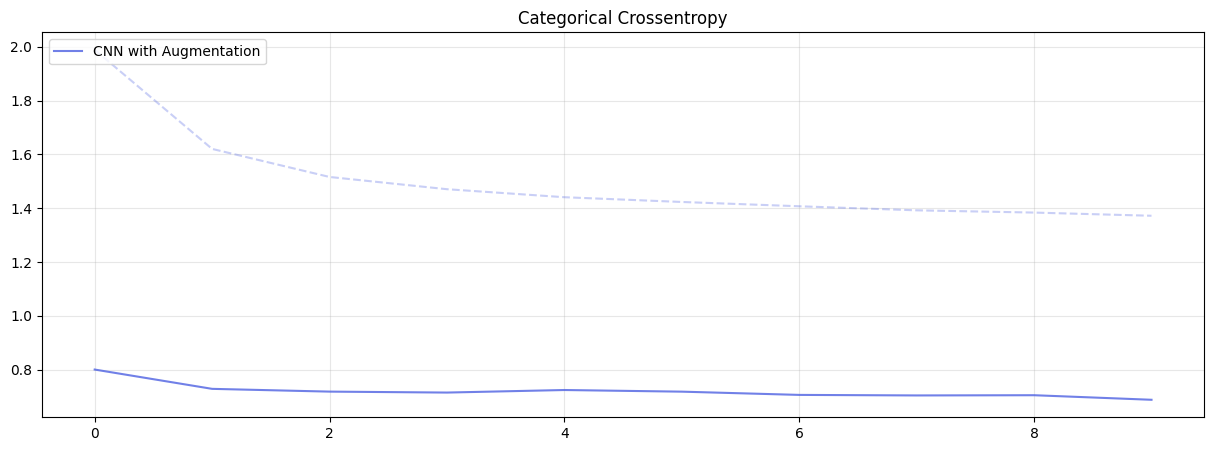

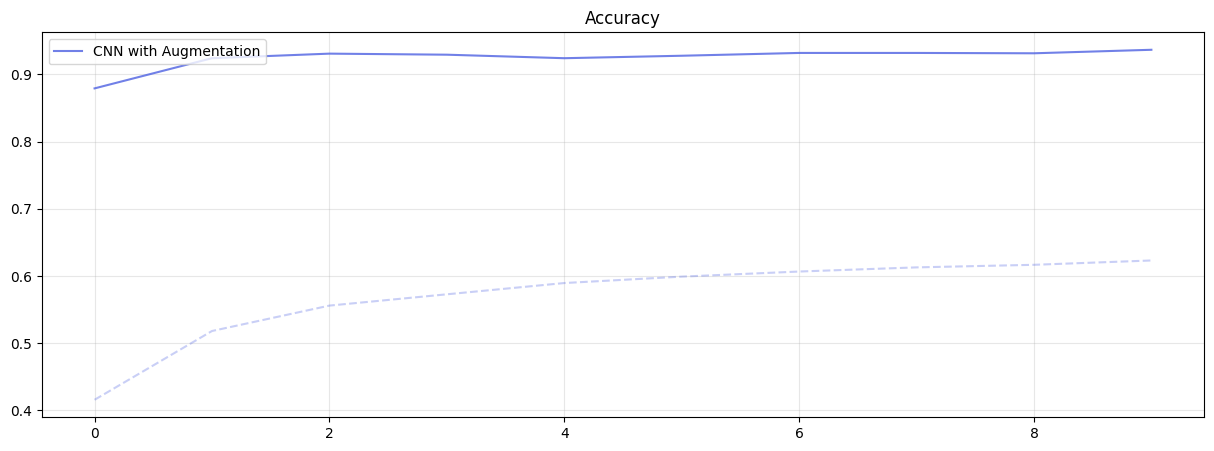

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### ⏬ Save the trained model (just in case of problems)

In [ ]:
model.save("ConvNeXtBase_01_trained.keras")
del model

### ⏫ Reload trained model

In [ ]:
model_convTL = tfk.models.load_model('ConvNeXtBase_01_trained.keras')

### Prepare for fine tuning

In [ ]:
# Set regularizer for added layers
model_convTL.get_layer("c_dense0").kernel_regularizer = tfk.regularizers.L1L2(l1=1.5e-4, l2=4e-4)
model_convTL.get_layer("c_output").kernel_regularizer = tfk.regularizers.L2(1.5e-5)

# Define Callbacks for fine tuning
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True)

reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5
    )

callbacks = [early_stopping, reduce_lr_on_plateau]


# Number of layers of convnext to unfreeze
TO_UNFREEZE = 180

# Helper function for unfreezing convnext layers
def unfreeze(model, N):
    for layer in model.get_layer('convnext_base').layers[:-N]:
        layer.trainable = False
    for layer in model.get_layer('convnext_base').layers[-N:]:
        layer.trainable = True

# Unfreeze layers and compile
unfreeze(model_convTL, TO_UNFREEZE)
model_convTL.compile(
	loss=tfk.losses.CategoricalCrossentropy(),
	optimizer=tfk.optimizers.AdamW(),
	metrics=['accuracy']
)
model_convTL.summary()
# Fine-tune
fine_history = model_convTL.fit(
    x = augmented_images,
    y = augmented_labels,
    class_weight=class_weights,
    validation_data=(X_val, y_val),
    epochs = 49,
    callbacks = callbacks,
    batch_size=BATCH_SIZE
).history

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 1024)                │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ c_dense0 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop0 (Dropout)                      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ c_output (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,698,696 (334.54 MB)

 Trainable params: 72,269,448 (275.69 MB)

 Non-trainable params: 15,429,248 (58.86 MB)

Epoch 1/49
180/180 ━━━━━━━━━━━━━━━━━━━━ 220s 853ms/step - accuracy: 0.5520 - loss: 1.5445 - val_accuracy: 0.9587 - val_loss: 0.2084 - learning_rate: 0.0010
Epoch 2/49
180/180 ━━━━━━━━━━━━━━━━━━━━ 148s 690ms/step - accuracy: 0.8154 - loss: 0.7466 - val_accuracy: 0.9598 - val_loss: 0.1448 - learning_rate: 0.0010
Epoch 3/49
180/180 ━━━━━━━━━━━━━━━━━━━━ 124s 688ms/step - accuracy: 0.8894 - loss: 0.5473 - val_accuracy: 0.9707 - val_loss: 0.1073 - learning_rate: 0.0010
Epoch 4/49
180/180 ━━━━━━━━━━━━━━━━━━━━ 142s 687ms/step - accuracy: 0.9226 - loss: 0.4736 - val_accuracy: 0.9728 - val_loss: 0.1140 - learning_rate: 0.0010
Epoch 5/49
180/180 ━━━━━━━━━━━━━━━━━━━━ 143s 691ms/step - accuracy: 0.9414 - loss: 0.3974 - val_accuracy: 0.9660 - val_loss: 0.1389 - learning_rate: 0.0010
Epoch 6/49
180/180 ━━━━━━━━━━━━━━━━━━━━ 140s 683ms/step - accuracy: 0.9482 - loss: 0.3660 - val_accuracy: 0.9713 - val_loss: 0.1209 - learning_rate: 0.0010
Epoch 7/49
180/180 ━━━━━━━━━━━━━━━━━━━━ 143s 691ms/step - accura

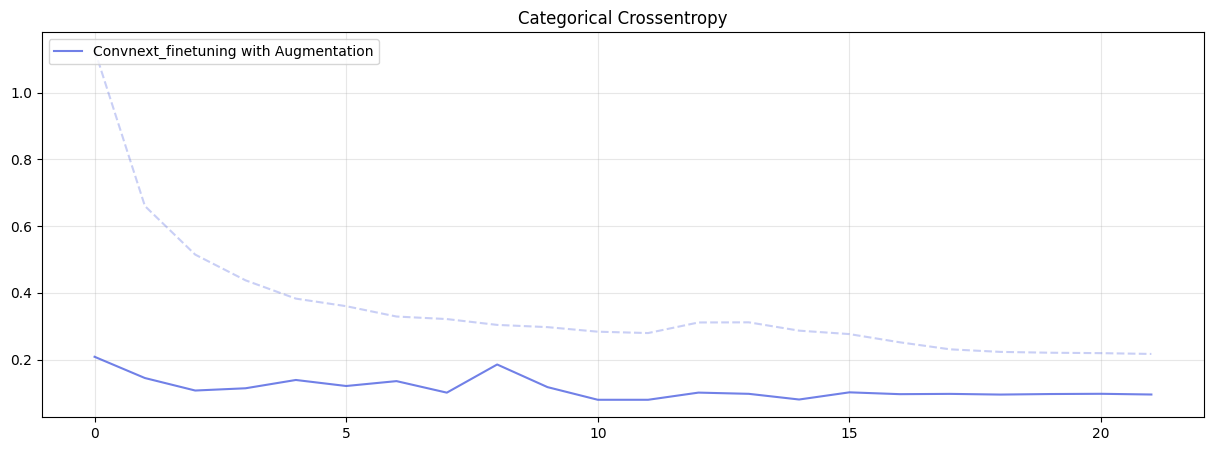

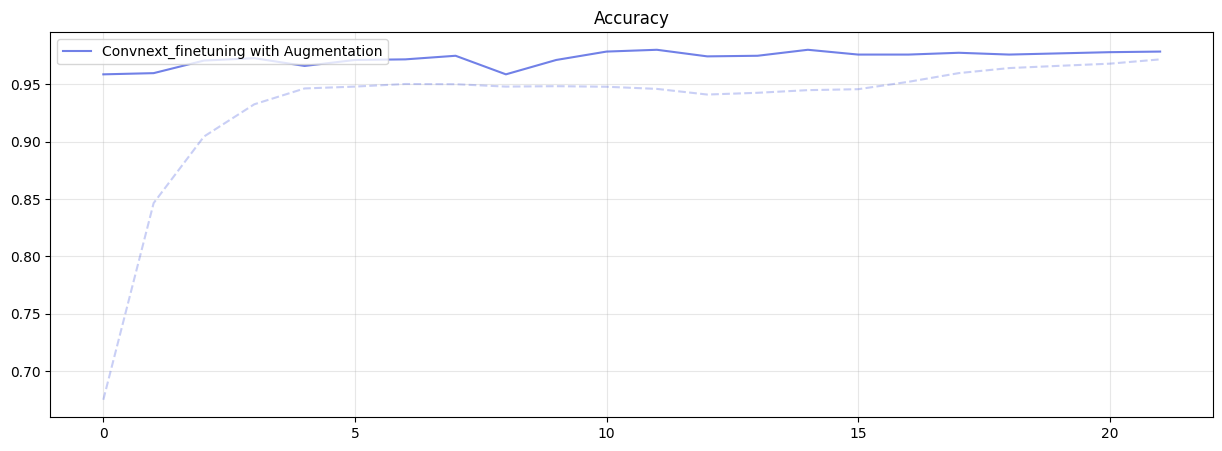

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(fine_history['loss'], alpha=.3, color='#4D61E1', linestyle='--')
plt.plot(fine_history['val_loss'], label='Convnext_finetuning with Augmentation', alpha=.8, color='#4D61E1')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(fine_history['accuracy'], alpha=.3, color='#4D61E1', linestyle='--')
plt.plot(fine_history['val_accuracy'], label='Convnext_finetuning with Augmentation', alpha=.8, color='#4D61E1')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### ⏬ Save fine tuned model

In [ ]:
model_convTL.save("ConvNeXtBase_01_tuned.keras")

### Evaluate

In [ ]:


# Evaluate the model on the test set
loss, accuracy = model_convTL.evaluate(X_test, to_categorical(y_test, NUM_CLASSES))

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9791 - loss: 0.0778
Test Loss: 0.0858
Test Accuracy: 0.9770
